<p style="color:yellow;font-size:18px;"><b>
Tanut Bumrungvongsiri  63340500026 <br>
Parapat patcharapimpisut 63340500046<br>
Ronnakon mekvimanloi 63340500051


# HW3.2: Neural Transition-Based Dependency Parsing


In this exercise, you are going to build a deep learning model for Neural Networks Transition-Based Dependency Parsing. A dependency parser analyzes the grammatical structure of a sentence, establishing relationships between “head” words and words which modify those heads. Your implementation will be a transition-based parser, which incrementally builds up a parse one step at a time.

To complete this exercise, you will need to complete the code and build a deep learning model for dependency parsing. 

We provide the code for data preparation and the skeleton for PartialParse class. You do not need to understand the code outside of this notebook. 


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/HW3-2.zip", "/content/HW3-2.zip")
# !tar -xf HW3-2.zip

## 1. Transition-Based Dependency Parsing

Your implementation will be a transition-based parser, which incrementally builds
up a parse one step at a time. At every step it maintains a partial parse, which is represented as follows:
- A stack of words that are currently being processed.
- A buffer of words yet to be processed.
- A list of dependencies predicted by the parser.

Initially, the stack only contains ROOT, the dependencies lists is empty, and the buffer contains all words
of the sentence in order. At each step, the parse applies a transition to the partial parse until its buffer is
empty and the stack is size 1. The following transitions can be applied:
- SHIFT: removes the first word from the buffer and pushes it onto the stack.
- LEFT-ARC: marks the second (second most recently added) item on the stack as a dependent of the
first item and removes the second item from the stack.
- RIGHT-ARC: marks the first (most recently added) item on the stack as a dependent of the second
item and removes the first item from the stack.

Your parser will decide among transitions at each state using a neural network classifier.

### TODO 1 (Written):
Go through the sequence of transitions needed for parsing the sentence “I parsed
this sentence correctly”. The dependency tree for the sentence is shown below. At each step, give the
configuration of the stack and buffer, as well as what transition was applied this step and what new
dependency was added (if any). The first three steps are provided below as an example.

Image --> https://drive.google.com/file/d/10jYgxDhsyolZGarcNTEdt6G2xB0l9iZU/view?usp=share_link 

Complete the following table (double click the table and fill in the rest):

| stack    |  buffer |  new dependency | transition |
| :------: |:------: | :-------------: | :--------: |
| \[ROOT\]            | \[I, parsed, this, sentence, correctly\] |          | Initial Configuration |
| \[ROOT, I\]         | \[parsed, this, sentence, correctly\]    |          | SHIFT |
| \[ROOT, I, parsed\] | \[this, sentence, correctly\]            |          | SHIFT |
| \[ROOT, parsed\]    | \[this, sentence, correctly\]            | parsed→I | LEFT-ARC |
| \[ROOT, parsed, this\] | \[sentence, correctly\]            |          | SHIFT |
| \[ROOT, parsed, this, sentence\] | \[correctly\]            |          | SHIFT |
| \[ROOT, parsed, sentence\]    | \[correctly\]            | sentence→this | LEFT-ARC |
| \[ROOT, parsed\]    | \[correctly\]            | parsed→sentence | RIGHT-ARC |
| \[ROOT, parsed, correctly\] | \[\]            |          | SHIFT |
| \[ROOT, parsed\] | \[\]            | parsed→correctly| RIGHT-ARC |
| \[ROOT\] | \[\]            | ROOT→parsed| RIGHT-ARC |

### TODO 2 (Coding):
Implement the __\_\_init\_\___ and __parse_step__ functions in the PartialParse class. Your code must past both of the following tests.

In [3]:
class PartialParse(object):
    def __init__(self, sentence):
        """Initializes this partial parse.

        Your code should initialize the following fields:
            self.stack: The current stack represented as a list with the top of the stack as the
                        last element of the list.
            self.buffer: The current buffer represented as a list with the first item on the
                         buffer as the first item of the list
            self.dependencies: The list of dependencies produced so far. Represented as a list of
                    tuples where each tuple is of the form (head, dependent).
                    Order for this list doesn't matter.

        The root token should be represented with the string "ROOT"

        Args:
            sentence: The sentence to be parsed as a list of words.
                      Your code should not modify the sentence.
        """
        # The sentence being parsed is kept for bookkeeping purposes. Do not use it in your code.
        self.sentence = sentence #--list

        ### YOUR CODE HERE
        #self.stack = ?  --> list
        #self.buffer = ? --> list
        #self.dependencies = ?  --> list
        self.stack = ["ROOT"]
        self.buffer = sentence.copy()
        self.dependencies = []
        ### END YOUR CODE

    def parse_step(self, transition):
        """Performs a single parse step by applying the given transition to this partial parse

        Args:
            transition: A string that equals "S", "LA", or "RA" representing the shift, left-arc,
                        and right-arc transitions. You can assume the provided transition is a legal
                        transition.
        """
        ### YOUR CODE HERE
        if transition == "S":
            self.stack.append(self.buffer[0])
            del self.buffer[0]

        elif transition == "LA":
            self.dependencies.append((self.stack[-1],self.stack[-2]))
            del self.stack[-2]

        elif transition == "RA":
            self.dependencies.append((self.stack[-2],self.stack[-1]))
            del self.stack[-1]

        ### END YOUR CODE

    def parse(self, transitions):
        """Applies the provided transitions to this PartialParse

        Args:
            transitions: The list of transitions in the order they should be applied
        Returns:
            dependencies: The list of dependencies produced when parsing the sentence. Represented
                          as a list of tuples where each tuple is of the form (head, dependent)
        """
        for transition in transitions:
            self.parse_step(transition)
        return self.dependencies

In [4]:
# Do not modify this code
def test_step(name, transition, stack, buf, deps,
              ex_stack, ex_buf, ex_deps):
    """Tests that a single parse step returns the expected output"""
    pp = PartialParse([])
    pp.stack, pp.buffer, pp.dependencies = stack, buf, deps

    pp.parse_step(transition)
    stack, buf, deps = (tuple(pp.stack), tuple(pp.buffer), tuple(sorted(pp.dependencies)))
    assert stack == ex_stack, \
        "{:} test resulted in stack {:}, expected {:}".format(name, stack, ex_stack)
    assert buf == ex_buf, \
        "{:} test resulted in buffer {:}, expected {:}".format(name, buf, ex_buf)
    assert deps == ex_deps, \
        "{:} test resulted in dependency list {:}, expected {:}".format(name, deps, ex_deps)
    print("{:} test passed!".format(name))


def test_parse_step():
    """Simple tests for the PartialParse.parse_step function
    Warning: these are not exhaustive
    """
    test_step("SHIFT", "S", ["ROOT", "the"], ["cat", "sat"], [],
              ("ROOT", "the", "cat"), ("sat",), ())
    test_step("LEFT-ARC", "LA", ["ROOT", "the", "cat"], ["sat"], [],
              ("ROOT", "cat",), ("sat",), (("cat", "the"),))
    test_step("RIGHT-ARC", "RA", ["ROOT", "run", "fast"], [], [],
              ("ROOT", "run",), (), (("run", "fast"),))


def test_parse():
    """Simple tests for the PartialParse.parse function
    Warning: these are not exhaustive
    """
    sentence = ["parse", "this", "sentence"]
    dependencies = PartialParse(sentence).parse(["S", "S", "S", "LA", "RA", "RA"])
    dependencies = tuple(sorted(dependencies))
    expected = (('ROOT', 'parse'), ('parse', 'sentence'), ('sentence', 'this'))
    assert dependencies == expected,  \
        "parse test resulted in dependencies {:}, expected {:}".format(dependencies, expected)
    print(sentence)
    assert tuple(sentence) == ("parse", "this", "sentence"), \
        "parse test failed: the input sentence should not be modified"
    print("parse test passed!")

In [5]:
test_parse_step()
test_parse()

SHIFT test passed!
LEFT-ARC test passed!
RIGHT-ARC test passed!
['parse', 'this', 'sentence']
parse test passed!


## 2. Setup and Preprocessing

In [6]:
from utils.parser_utils import minibatches, load_and_preprocess_data

Preparing data. We will use a subset of Penn Treebank and pretrained embeddings in this task

We are now going to train a neural network to predict, given the state of the stack, buffer, and dependencies, which transition should be applied next. First, the model extracts a feature vector representing the current state. We will be using the feature set presented in the original neural dependency parsing paper: A Fast and Accurate Dependency Parser using Neural Networks. 

The function extracting these features has been implemented for you in parser_utils. This feature vector consists of a list of tokens (e.g., the last word in the stack, first word in the buffer, dependent of the second-to-last word in the stack if there is one, etc.). They can be represented as a list of integers.

In [7]:
parser, embeddings, train_examples, dev_set, test_set = load_and_preprocess_data(True)

Loading data...
took 2.02 seconds
Building parser...
took 0.03 seconds
Loading pretrained embeddings...
took 2.61 seconds
Vectorizing data...
took 0.05 seconds
Preprocessing training data...
took 1.16 seconds


In [8]:
print(len(train_examples), len(dev_set), len(test_set))

48390 500 500


In [9]:
print(train_examples[0])

([5155, 5155, 5156, 91, 113, 806, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 83, 83, 84, 40, 41, 42, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83], [0, 0, 1], 2)


In [10]:
print(dev_set[0])

{'word': [5156, 5154, 524, 88, 85, 212, 2077, 92, 715, 821, 843, 2207, 95, 122, 5154, 241, 85, 119, 4617, 655, 215, 181, 425, 350, 86, 1114, 222, 1958, 3213, 89, 85, 168, 93, 397, 88, 2079, 2080, 87], 'pos': [84, 43, 44, 40, 41, 42, 66, 51, 42, 42, 48, 39, 64, 58, 50, 70, 41, 43, 39, 39, 39, 58, 50, 39, 45, 56, 41, 43, 39, 52, 41, 39, 60, 39, 40, 43, 44, 46], 'head': [-1, 2, 10, 6, 6, 6, 2, 6, 9, 6, 0, 10, 14, 14, 11, 22, 20, 20, 20, 20, 22, 22, 14, 22, 14, 14, 28, 28, 25, 33, 31, 33, 31, 28, 36, 36, 33, 10], 'label': [-1, 25, 5, 9, 24, 28, 8, 36, 28, 19, 0, 17, 5, 11, 32, 4, 24, 25, 28, 28, 5, 11, 3, 17, 30, 13, 24, 25, 17, 9, 24, 21, 9, 8, 9, 25, 8, 30]}


In [11]:
embeddings

array([[-2.448082  ,  0.51401836, -0.4541984 , ...,  1.1572894 ,
        -0.49667835, -0.9342138 ],
       [ 0.7385327 , -1.2553197 ,  0.34999347, ...,  0.59224594,
        -0.27252474,  0.11436779],
       [ 0.33159333,  0.8004578 ,  0.8101017 , ..., -0.0227793 ,
        -0.5650982 , -0.23411095],
       ...,
       [ 0.02862711,  1.3070581 , -0.36724645, ...,  0.45296657,
        -0.19763951,  0.0573558 ],
       [-0.73885906, -0.7840838 ,  0.01170035, ...,  0.8510004 ,
        -0.9545991 , -0.9046545 ],
       [-0.50863945,  1.3147928 ,  0.8947655 , ..., -0.4586601 ,
        -0.24149227,  0.4821751 ]], dtype=float32)

In [12]:
vocab = embeddings.shape[0]
dim = embeddings.shape[1]

print(embeddings.shape)

(5157, 50)


Get the full batch of our subset data

In [13]:
minibatch_gen = minibatches(train_examples, len(train_examples))
x_train, y_train = minibatch_gen.__next__()

In [14]:
print(x_train.shape)
print(y_train.shape)

(48390, 36)
(48390, 3)


You can use parser.id2tok[word_id] to lookup the word in English.

In [15]:
for word_id in x_train[0]:
  print(parser.id2tok[word_id])

instead
said
consider
using
treasury
debt
rtc
<NULL>
should
<NULL>
the
<NULL>
,
,
gao
<NULL>
<NULL>
<NULL>
<p>:RB
<p>:VBD
<p>:VB
<p>:VBG
<p>:NNP
<p>:NN
<p>:NNP
<p>:<NULL>
<p>:MD
<p>:<NULL>
<p>:DT
<p>:<NULL>
<p>:,
<p>:,
<p>:NNP
<p>:<NULL>
<p>:<NULL>
<p>:<NULL>


In [16]:
y_train[0]

array([1., 0., 0.])

## 3. Model

In [17]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense, Reshape, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

### TODO 3 (Coding):
Build and train a tensroflow keras model to predict an action for each state of of the input. This is a simple classification task. 
- The input and output of the model must match the dimention of x_train and y_train.
- The model must use the provided pretrained embeddings
- The model could comprise of only a feedforward layer and a dropout
- Training loss should be around 0.1 or below, and training categorical_accuracy above 0.94

In [18]:
# Write your code here
model = Sequential()
model.add(Input(shape=(36,)))
model.add(Embedding(vocab, dim, weights=[embeddings] , trainable = False))
model.add(Dense(70 , activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(50 , activation = "relu"))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(20, activation = "relu"))
model.add(Dense(3 ,  activation = tf.keras.activations.softmax))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 50)            257850    
                                                                 
 dense (Dense)               (None, 36, 70)            3570      
                                                                 
 dropout (Dropout)           (None, 36, 70)            0         
                                                                 
 dense_1 (Dense)             (None, 36, 50)            3550      
                                                                 
 dropout_1 (Dropout)         (None, 36, 50)            0         
                                                                 
 flatten (Flatten)           (None, 1800)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                3

In [19]:
# Write your code here
model.compile(optimizer=Adam(learning_rate=0.001) , loss='categorical_crossentropy',metrics=['acc'])
hist = model.fit(x_train,y_train,epochs=30,batch_size=32)

Epoch 1/30
1513/1513 [==============================] - 10s 6ms/step - loss: 0.3495 - acc: 0.8566
Epoch 2/30
1513/1513 [==============================] - 8s 5ms/step - loss: 0.2273 - acc: 0.9096
Epoch 3/30
1513/1513 [==============================] - 8s 5ms/step - loss: 0.1960 - acc: 0.9219
Epoch 4/30
1513/1513 [==============================] - 8s 5ms/step - loss: 0.1760 - acc: 0.9303
Epoch 5/30
1513/1513 [==============================] - 8s 5ms/step - loss: 0.1631 - acc: 0.9360
Epoch 6/30
1513/1513 [==============================] - 8s 5ms/step - loss: 0.1529 - acc: 0.9415
Epoch 7/30
1513/1513 [==============================] - 8s 5ms/step - loss: 0.1442 - acc: 0.9440
Epoch 8/30
1513/1513 [==============================] - 9s 6ms/step - loss: 0.1355 - acc: 0.9469
Epoch 9/30
1513/1513 [==============================] - 9s 6ms/step - loss: 0.1277 - acc: 0.9506
Epoch 10/30
1513/1513 [==============================] - 9s 6ms/step - loss: 0.1260 - acc: 0.9518
Epoch 11/30
1513/1513 [=====

In [29]:
import matplotlib.pyplot as plt

# summarize history for accuracy
def plot_history(history2):
    plt.plot(history2.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history2.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

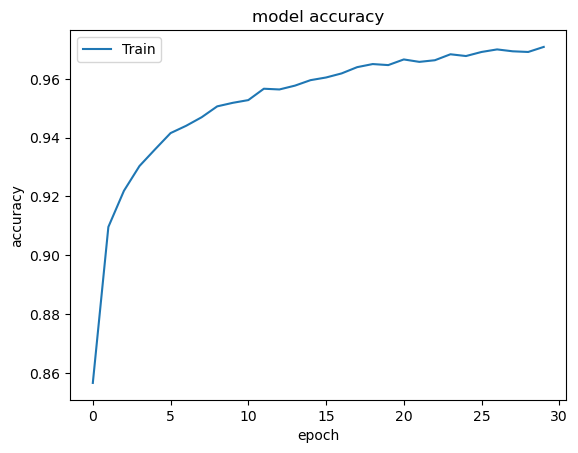

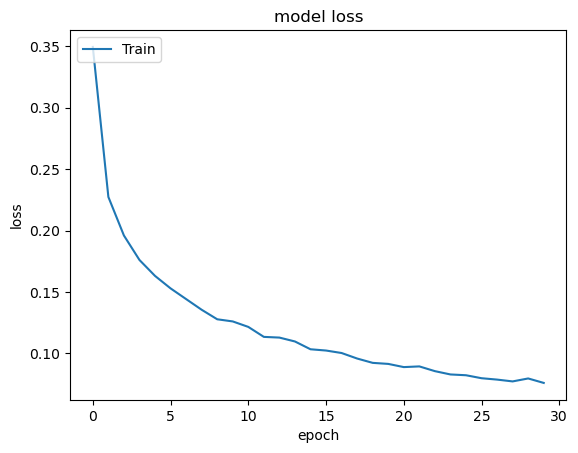

In [30]:
plot_history(hist)

In [21]:
model.evaluate(x_train,y_train)

1513/1513 [==============================] - 8s 5ms/step - loss: 0.0402 - acc: 0.9867


[0.04019472375512123, 0.9866501092910767]

<b>Model use 30 epoch and 32 batchsize<br></b>
accuracy 0.9867 <br>
loss 0.0402 <br>